In [2]:
# Alle folgenden imports sind nötig!

import matplotlib.pyplot as plt
import numpy as np
import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import tensorflow as tf

In [3]:
# Konfiguration der Tensorflowparameter
# https://www.intel.com/content/www/us/en/developer/articles/guide/guide-to-tensorflow-runtime-optimizations-for-cpu.html

import os
os.environ["OMP_NUM_THREADS"] = '10'

In [4]:
# Trainingsdatenset und Bewertungsdatenset erstellen

# Parameter rescale=1.0/255 skaliert die Pixelwerte der Bilder zwischen 0 und 1 
#(da Pixelwerte ursprünglich zwischen 0 und 255 liegen)
# validation_split 0.3 --> 30% für Validation, 70% für Training
img_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)
batch_size = 32 # batch size gibt an wie viele Bilder pro Schritt bearbeitet werden
target_size =(300, 300) # Skalierung der Bilder
train_ds = img_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size,  
                                                 subset="training",
                                                 class_mode='categorical',
                                                 shuffle=True, # mischen von Daten, verhindert das Lernen von Reihenfolge
                                                 seed = 5, #hilft, die Reihenfolge des Mischens reproduzierbar zu machen
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                 )

validation_ds = img_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size, 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 seed = 20, 
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                )


Found 11967 images belonging to 8 classes.
Found 5125 images belonging to 8 classes.


In [5]:
# Dictionary um den Zelltyp mit argmax festzuhalten
agx_to_string = {
                     0: 'basophil',
                     1: 'eosinophil',
                     2: 'erythroblast',
                     3: 'immunoglobulin',
                     4: 'lymphocyte',
                     5: 'monocyte',
                     6: 'neutrophil',
                     7: 'platelet'
                   }




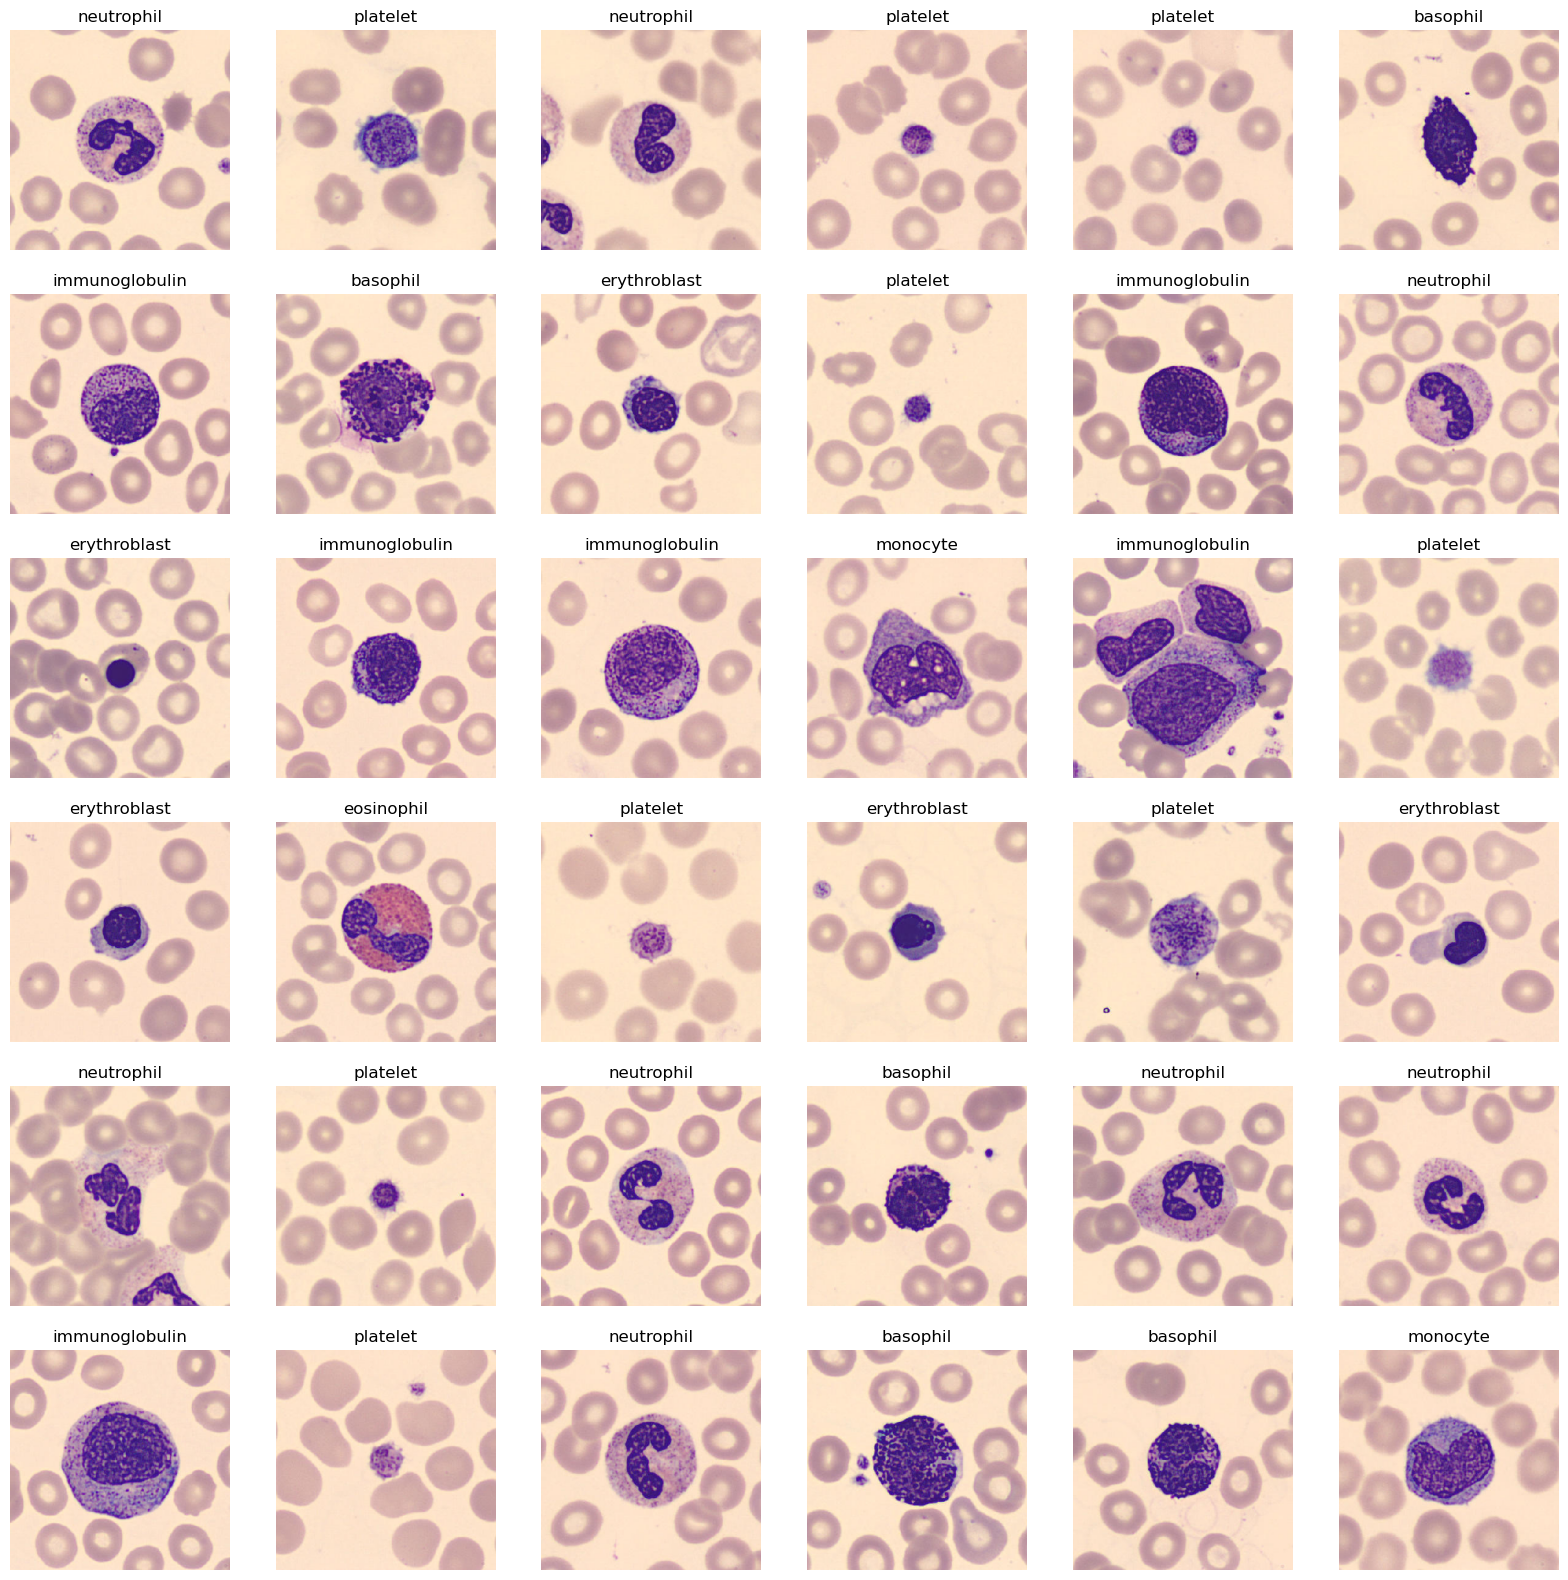

In [6]:
# Beispielbilder aus der Gesamtheit anzeigen
plt.figure(figsize=(20, 20))
plot_dim = 6
counter = 1

for img in train_ds:
    plt.subplot(plot_dim, plot_dim, counter)
    plt.axis('off')
    plt.imshow(img[0][0]) # nur ein Bild von (plot_dim²) pro Durchgang
    plt.title(agx_to_string[np.argmax(img[-1])])
    
    if counter >= plot_dim**2:
        break
    else:
        counter += 1

In [7]:
from keras.layers import Dropout
# Deep Learning Modell mit keras erstellen

model = keras.models.Sequential() #Lineare Stapelung von Schichten, alle Schichten ein Eingan und ein Ausgang
model.add(keras.Input(shape=(300, 300, 3))) #Input Layer 300x300 Pixel, drei Farbkanäle RGB
# 2D Konvolutionschicht, 16 Filter (Kerne) mit einer Grösse von 3x3 Pixel
#padding='same': Ausgabegröße der Schicht bleibt gleich der Eingabegröße
model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2, padding='same'))
#Dropout-Schicht mit Rate von 0.2. In jedem Trainingsschritt werden zufällig 20% der Neuronen ausgeschaltet
#um Overfitting zu reduzieren.
model.add(Dropout(0.2))
model.add(keras.layers.Flatten())
# Layer mit 128 und 64 Neuronen
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
# Ausgabeschicht mit 8 Neuronen (entprechend der Anzahl Klassen)
model.add(keras.layers.Dense(8, activation='softmax'))
# Kompliliert mit adam und categoriacal crossentropy weil es mehrere Klassen hat
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Model Summary ausgeben
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 150, 16)      0         
                                                                 
 flatten (Flatten)           (None, 360000)            0         
                                                                 
 dense (Dense)               (None, 128)               46080128  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
# Modell trainieren (Anzahl Iterationen mit 'epochs' Parameter einstellen)
model.fit(train_ds, epochs=9, validation_data=validation_ds)

Epoch 1/9
374/374 [==============================] - ETA: 0s - loss: 1.6138 - accuracy: 0.6745

In [11]:
# Minimale und maximale Werte vom Training

min_loss_train = min(model.history.history['loss'])
min_loss_val = min(model.history.history['val_loss'])
                
max_acc_train = max(model.history.history['accuracy'])
max_acc_val = max(model.history.history['val_accuracy'])


print('Minimaler Verlustwert aus dem Trainingsdatensatz: ', round(min_loss_train*100, 2), '%')
print('Minimaler Verlustwert aus dem Validierungsdatensatz: ', round(min_loss_val*100, 2), '%')
print()
print('Maximale Genauigkeit des Trainingsdatensatzes: ', round(max_acc_train*100, 2), '%')
print('Maximale Genauigkeit des Validierungsdatensatzes: ', round(max_acc_val*100, 2), '%')

Minimaler Verlustwert aus dem Trainingsdatensatz:  11.45 %
Minimaler Verlustwert aus dem Validierungsdatensatz:  46.15 %

Maximale Genauigkeit des Trainingsdatensatzes:  96.16 %
Maximale Genauigkeit des Validierungsdatensatzes:  85.39 %


Text(0, 0.5, 'Verlust des Funktionswert')

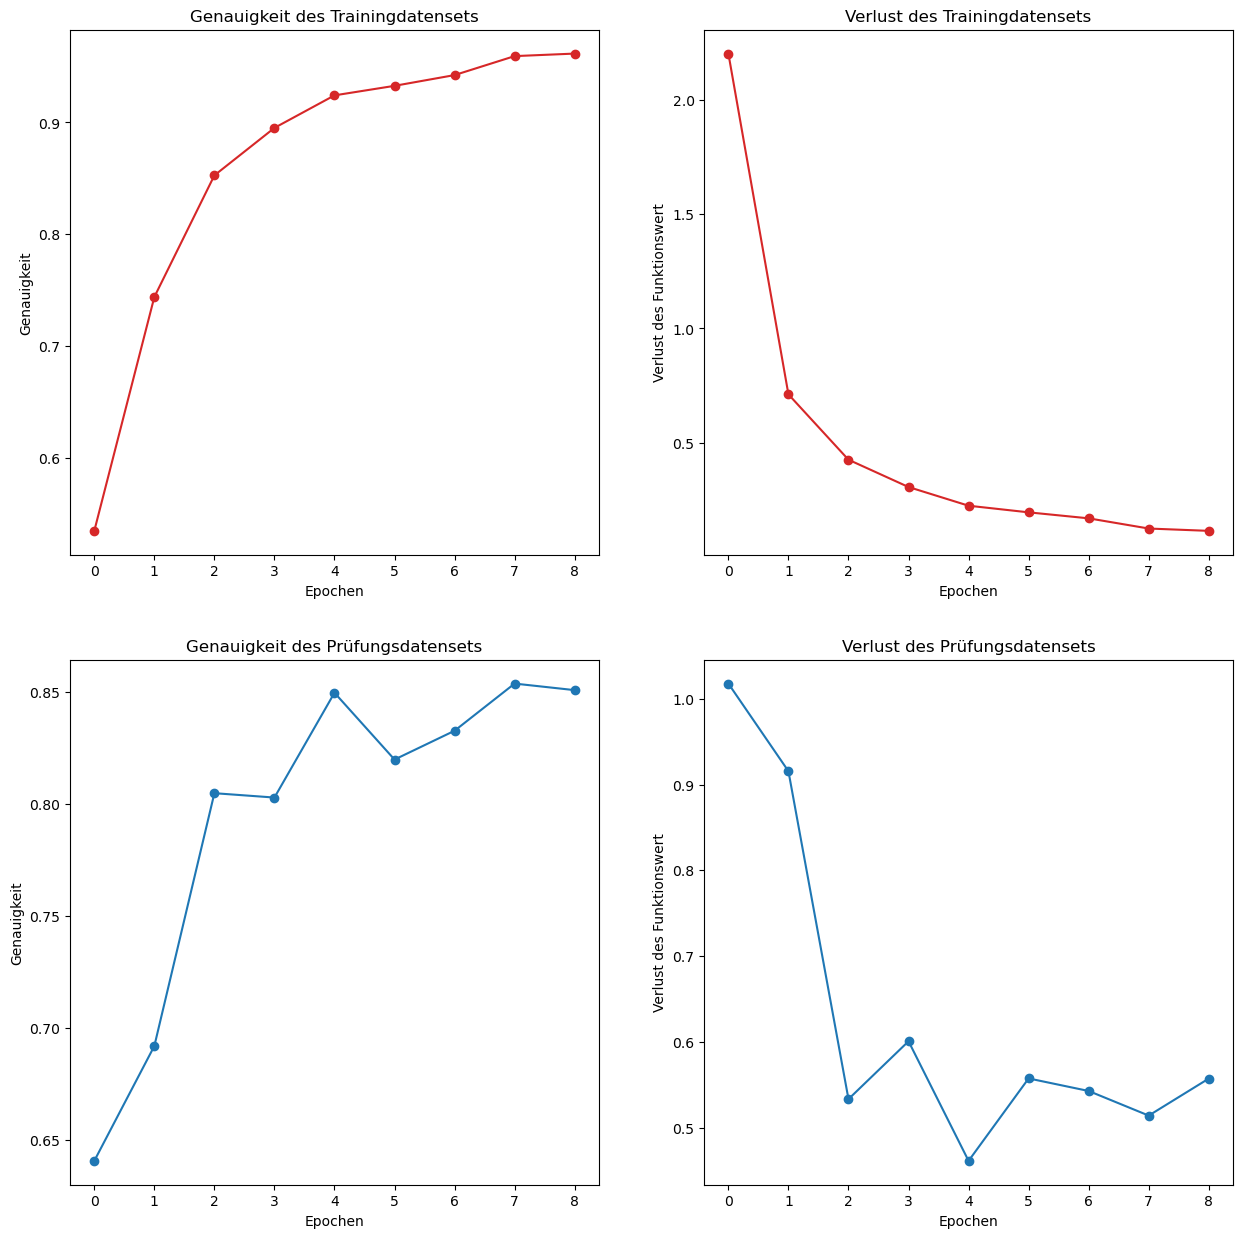

In [12]:
# Entwicklung des Trainings

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(model.history.history['accuracy'], color='tab:red', marker='o')
plt.title('Genauigkeit des Trainingdatensets')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')

plt.subplot(2, 2, 2)
plt.plot(model.history.history['loss'], color='tab:red', marker='o')
plt.title('Verlust des Trainingdatensets')
plt.xlabel('Epochen')
plt.ylabel('Verlust des Funktionswert')

plt.subplot(2, 2, 3)
plt.plot(model.history.history['val_accuracy'], color='tab:blue', marker='o')
plt.title('Genauigkeit des Prüfungsdatensets')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')

plt.subplot(2, 2, 4)
plt.plot(model.history.history['val_loss'], color='tab:blue', marker='o')
plt.title('Verlust des Prüfungsdatensets')
plt.xlabel('Epochen')
plt.ylabel('Verlust des Funktionswert')

1/1 [==============================] - 0s 175ms/step


Valalidation Score:  83.33 %


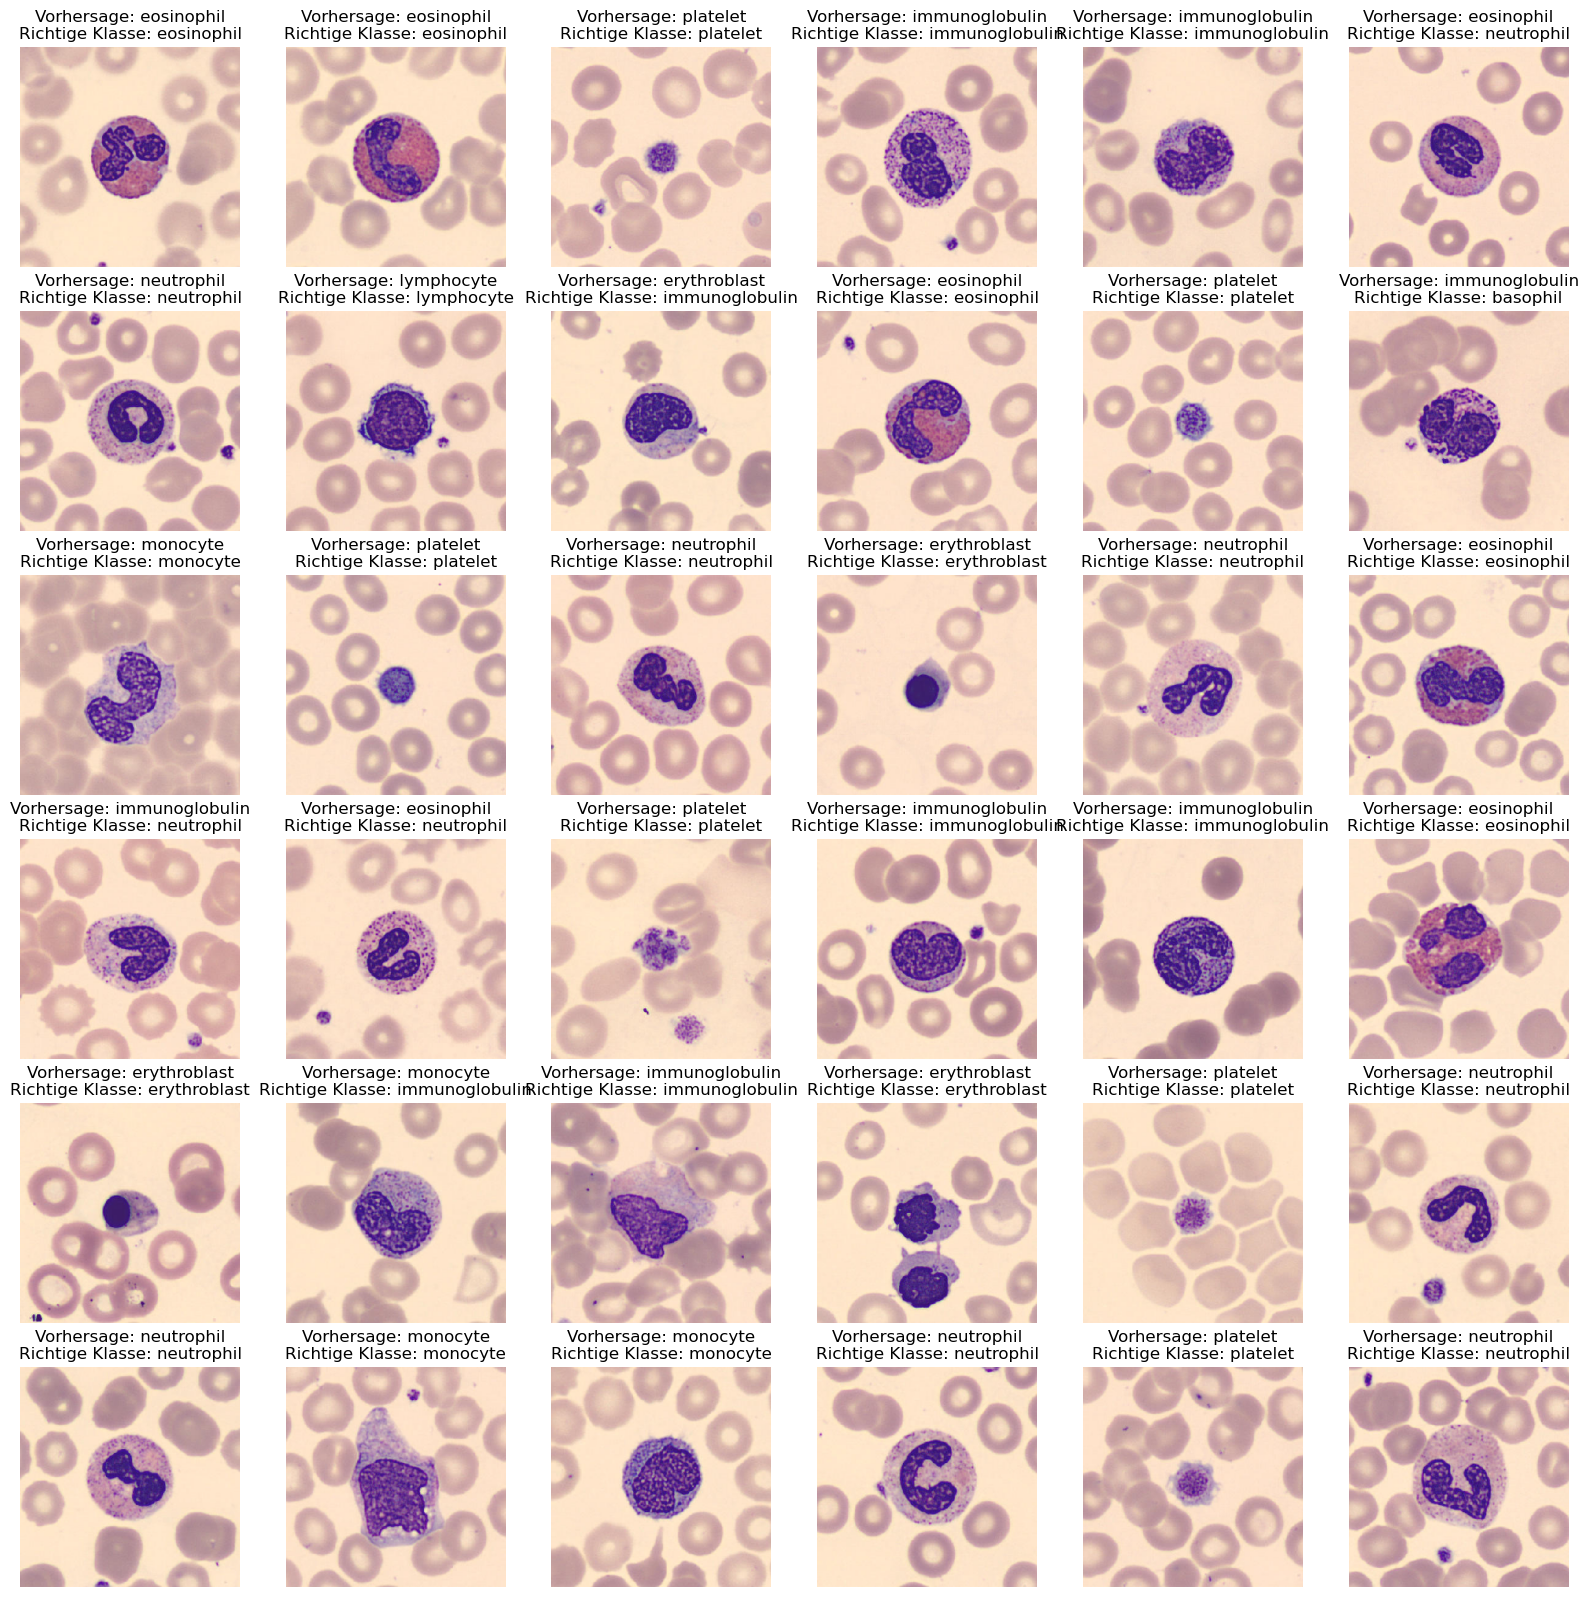

In [13]:
# Resultate anzeigen:
# - Beispielbilder aus dem Validationdatensatz vom Modell vorhersagen lassen

#Zeichenfläche für die Visualisierung mit einer Größe von 20x20 Einheiten
plt.figure(figsize=(20, 20))
#plot_dim = 6, bestimmt wie viele Bilder pro Zeile und Spalte in der Visualisierung gezeigt werden.
plot_dim = 6
#counter = Anzahl der verarbeiteten Bilder zählen.
counter = 1
#val = korrekt vorhergesagten Bilder zählen.
val = 0

#Schleife durchläuft jedes Bild (img) im Validierungsdatensatz (validation_ds).
for img in validation_ds:
    #Für jedes Bild wird ein Unterplot erstellt. plt.subplot(plot_dim, plot_dim, counter) 
    # teilt Zeichenfläche in plot_dim * plot_dim Bereiche 
    # wählt den durch counter spezifizierten Bereich für das aktuelle Bild.
    plt.subplot(plot_dim, plot_dim, counter)
    plt.axis('off')
    #Das Modell macht eine Vorhersage für das aktuelle Bild. 
    plt.imshow(img[0][0]) # Zeigt erstes Bild des aktuelen Batches
    predict = agx_to_string[np.argmax(model.predict(img[0])[0])]
    real_class = agx_to_string[np.argmax(img[-1])]

    plt.title(f'Vorhersage: {predict}\nRichtige Klasse: {real_class}')
    
    if {predict} == {real_class}:
        val += 1
    
    if counter >= plot_dim**2:
        break
    else:
        counter += 1
        
print('\n\nValalidation Score: ', round((val/counter)*100, 2), '%')

Found 11967 images belonging to 8 classes.
374/374 [==============================] - 119s 318ms/step


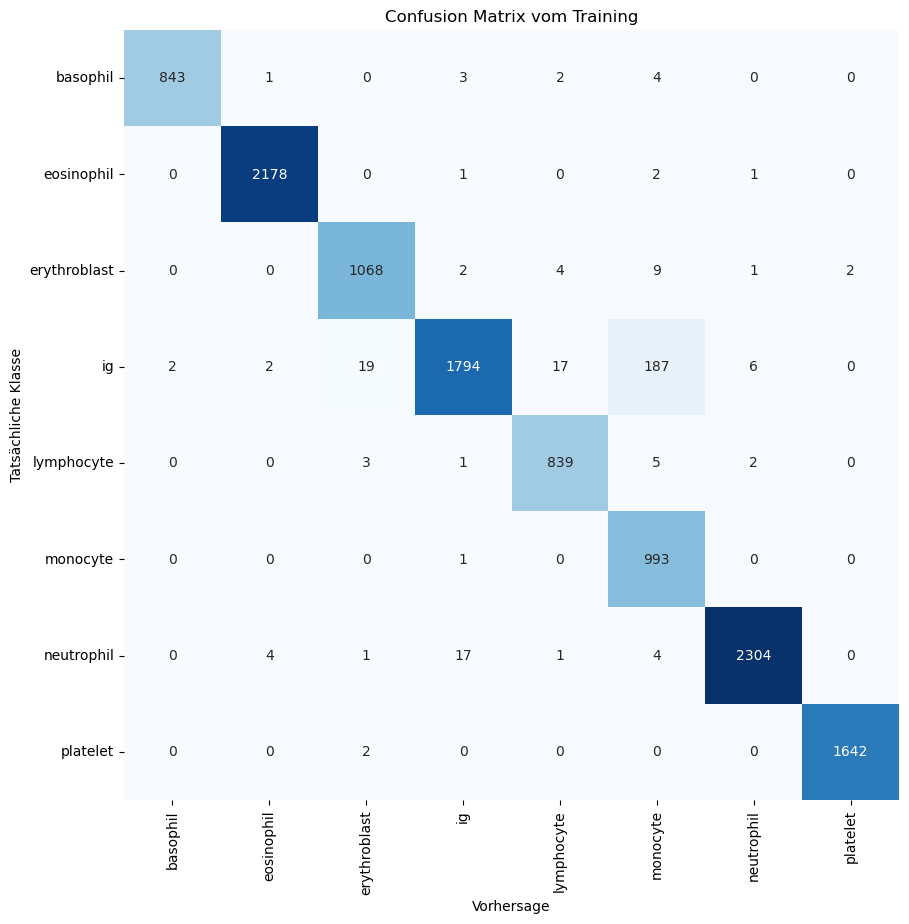

In [14]:
 from sklearn.metrics import confusion_matrix
import seaborn as sns

# Erstellen eines neuen ImageDAtaGenerator für die Confusion Matrix des Trainings
train_generator_for_cm = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# Neuen Datensatzgenerator von den gleichen Daten erstellen ohne Shuffle
# Mischen ausschalten, da mischen der Daten die Reihenfolge der Bilder und ihrer entsprechenden Labels verändert,
# was bedeutet, dass die Vorhersagen des Modells nicht mehr den tatsächlischen Labels zugeordnet werden können.
train_ds_for_cm = train_generator_for_cm.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size, 
                                                 subset="training",
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 seed = 5,               
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                )


# Vorhersage für den gesamtern Validierungsdatensatz generieren
predictions = model.predict(train_ds_for_cm)
predicted_classes = np.argmax(predictions, axis=1)

# Die richtigen Klassenlabels erhalten
real_classes = train_ds_for_cm.classes
class_labels = list(train_ds_for_cm.class_indices.keys())

# Berechnen der Confusion Matrix
confusion_m = confusion_matrix(real_classes, predicted_classes)

# Plotten der Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_m, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix vom Training')
plt.show()

Found 5125 images belonging to 8 classes.
161/161 [==============================] - 55s 339ms/step


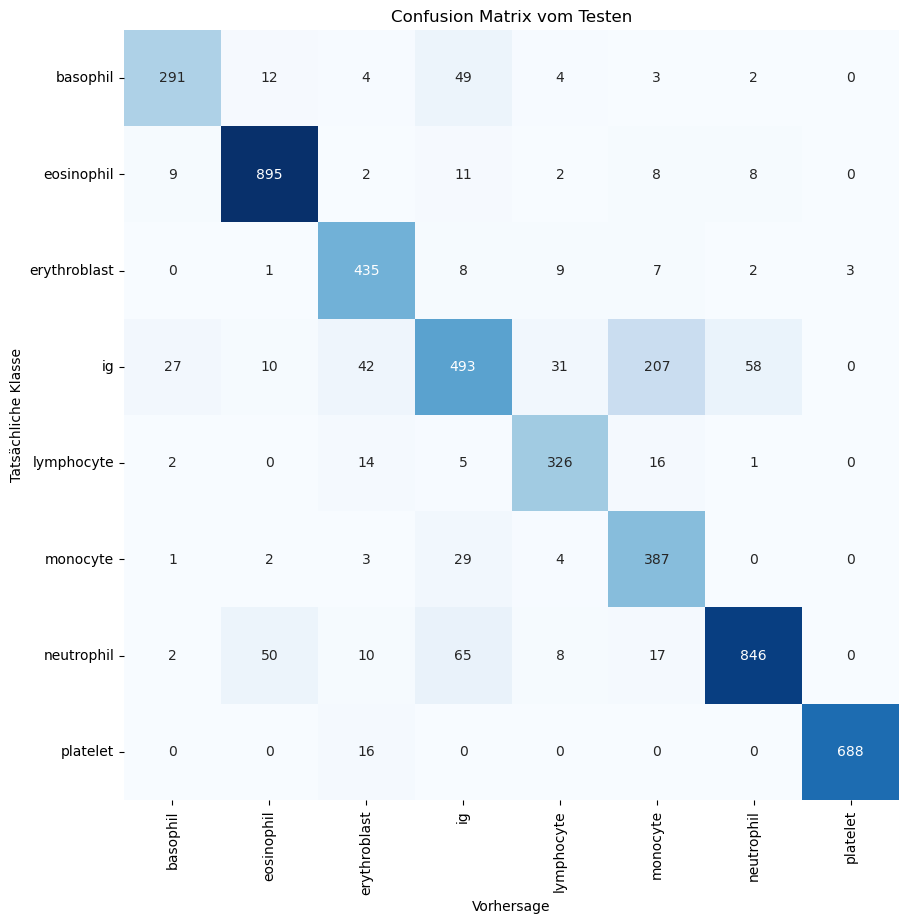

In [15]:
### von hier 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Erstellen eines neuen ImageDAtaGenerator für die Confusion Matrix des Tests
val_generator_for_cm = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# Neuen Datensatzgenerator von den gleichen Daten erstellen ohne Shuffle
# Mischen ausschalten, da mischen der Daten die Reihenfolge der Bilder und ihrer entsprechenden Labels verändert,
# was bedeutet, dass die Vorhersagen des Modells nicht mehr den tatsächlischen Labels zugeordnet werden können.
validation_ds_for_cm = val_generator_for_cm.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size, 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 seed = 20,               
                                                 #seed hier und oben gleich setzen
                                                 #evt auch training confusion machen
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                )


# Vorhersage für den gesamtern Validierungsdatensatz generieren
predictions = model.predict(validation_ds_for_cm)
predicted_classes = np.argmax(predictions, axis=1)
#### bis hier mit 3 verschiedenen seed, macht man cross validation

# Die richtigen Klassenlabels erhalten
real_classes = validation_ds_for_cm.classes
class_labels = list(validation_ds_for_cm.class_indices.keys())

# Berechnen der Confusion Matrix
confusion_m = confusion_matrix(real_classes, predicted_classes)

# Plotten der Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_m, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix vom Testen')
plt.show()

Found 5125 images belonging to 8 classes.
161/161 [==============================] - 54s 337ms/step


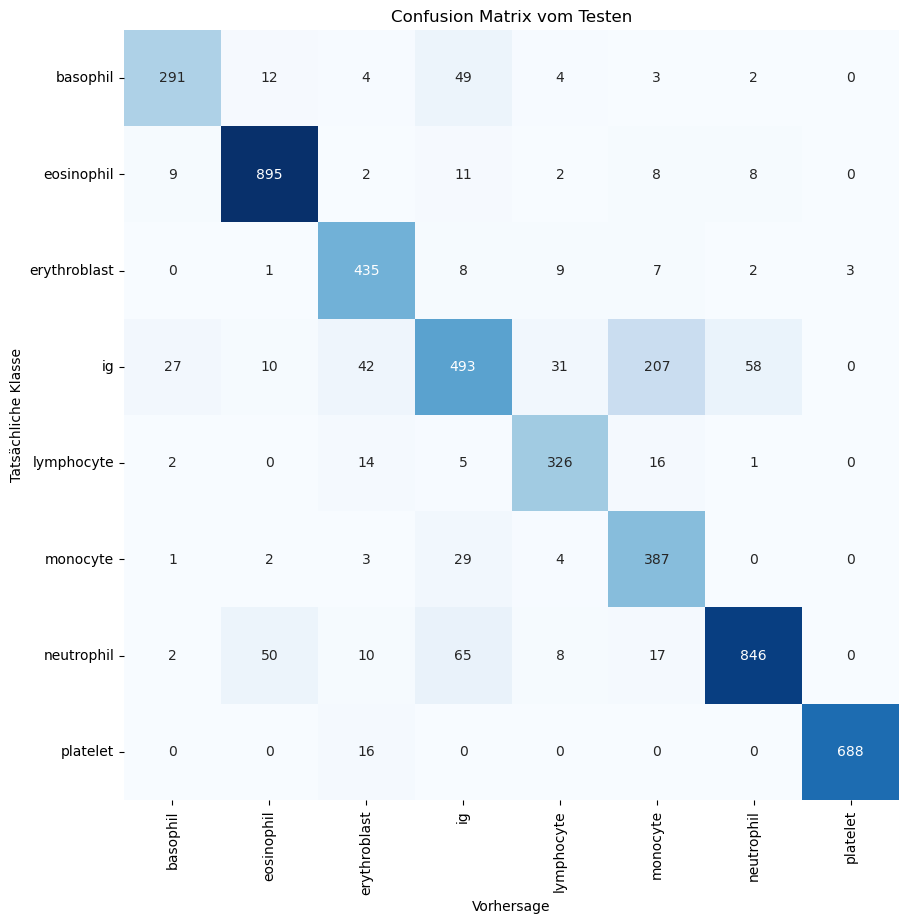

161/161 [==============================] - 48s 295ms/step - loss: 0.5574 - accuracy: 0.8509
Verlust: 0.5574046969413757
Genauigkeit: 0.8509268164634705


In [16]:
# Erstellen eines neuen ImageDAtaGenerator für die Confusion Matrix des Tests
val_generator_for_cm = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# Neuen Datensatzgenerator von den gleichen Daten erstellen ohne Shuffle
# Mischen ausschalten, da mischen der Daten die Reihenfolge der Bilder und ihrer entsprechenden Labels verändert,
# was bedeutet, dass die Vorhersagen des Modells nicht mehr den tatsächlischen Labels zugeordnet werden können.
validation_ds_for_cm = val_generator_for_cm.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size, 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 seed = 6,               
                                                 #seed hier und oben gleich setzen
                                                 #evt auch training confusion machen
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                )
# Vorhersage für den gesamten Validierungsdatensatz generieren
predictions = model.predict(validation_ds_for_cm)
predicted_classes = np.argmax(predictions, axis=1)

# Die richtigen Klassenlabels erhalten
real_classes = validation_ds_for_cm.classes
class_labels = list(validation_ds_for_cm.class_indices.keys())

# Berechnen der Confusion Matrix
confusion_m = confusion_matrix(real_classes, predicted_classes)

# Plotten der Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_m, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix vom Testen')
plt.show()

#Leistung mit model.evaluate bewerten
evaluation_metrics = model.evaluate(validation_ds_for_cm)

# Ausgabe der Bewertungsergebnisse
print("Verlust:", evaluation_metrics[0])
print("Genauigkeit:", evaluation_metrics[1])

Found 5125 images belonging to 8 classes.
161/161 [==============================] - 54s 335ms/step


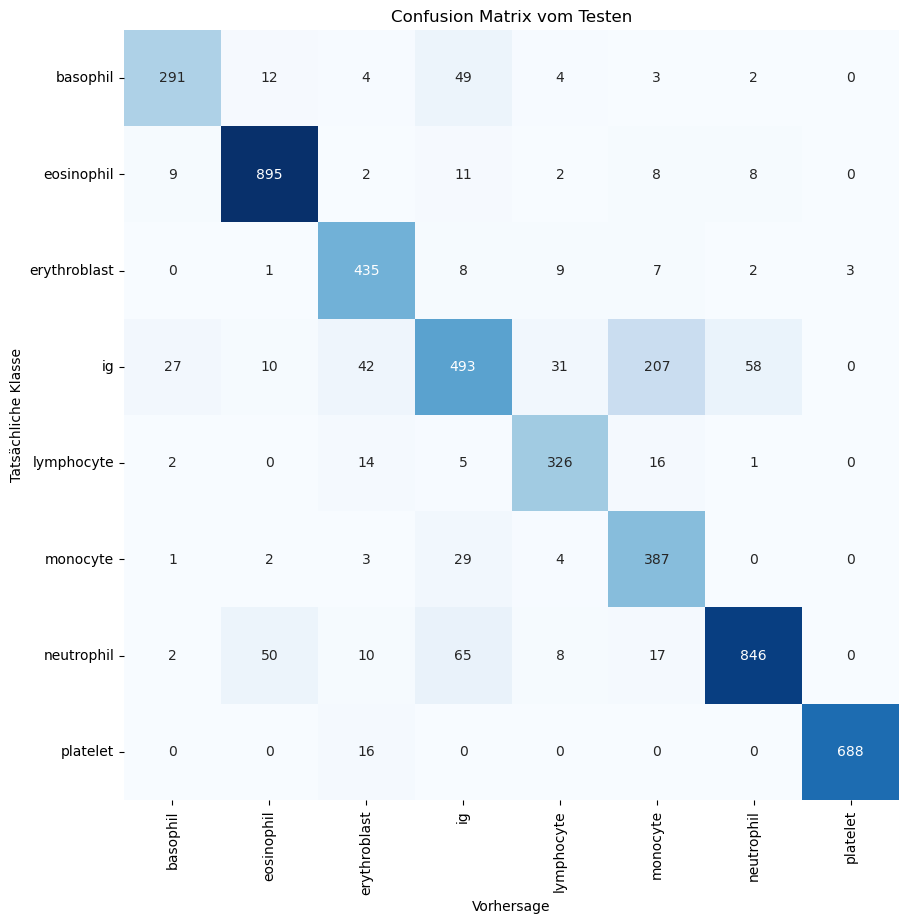

161/161 [==============================] - 52s 325ms/step - loss: 0.5574 - accuracy: 0.8509
Verlust: 0.5574046969413757
Genauigkeit: 0.8509268164634705


In [19]:
# Erstellen eines neuen ImageDAtaGenerator für die Confusion Matrix des Tests
val_generator_for_cm = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# Neuen Datensatzgenerator von den gleichen Daten erstellen ohne Shuffle
# Mischen ausschalten, da mischen der Daten die Reihenfolge der Bilder und ihrer entsprechenden Labels verändert,
# was bedeutet, dass die Vorhersagen des Modells nicht mehr den tatsächlischen Labels zugeordnet werden können.
tf.random.set_seed(42)
validation_ds_for_cm = val_generator_for_cm.flow_from_directory(batch_size=batch_size,
                                                 directory='images/archive/bloodcells_dataset',
                                                 target_size=target_size, 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 seed = 7,               
                                                 classes=('basophil', 
                                                          'eosinophil', 
                                                          'erythroblast', 
                                                          'ig', 
                                                          'lymphocyte', 
                                                          'monocyte', 
                                                          'neutrophil', 
                                                          'platelet')
                                                )
# Vorhersage für den gesamten Validierungsdatensatz generieren
predictions = model.predict(validation_ds_for_cm)
predicted_classes = np.argmax(predictions, axis=1)

# Die richtigen Klassenlabels erhalten
real_classes = validation_ds_for_cm.classes
class_labels = list(validation_ds_for_cm.class_indices.keys())

# Berechnen der Confusion Matrix
confusion_m = confusion_matrix(real_classes, predicted_classes)

# Plotten der Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_m, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix vom Testen')
plt.show()

#Leistung mit model.evaluate bewerten
evaluation_metrics = model.evaluate(validation_ds_for_cm)

# Ausgabe der Bewertungsergebnisse
print("Verlust:", evaluation_metrics[0])
print("Genauigkeit:", evaluation_metrics[1])